# NPD Field data analysis and visualisation
## https://factpages.npd.no/en/field/tableview/overview
This notebook contains analysis and visualisations of the data available for export under the 'Field' tab at the link above.

The process is to specify a Company licensee and display the Fields they have an interest in. From this, the in place volumes and reserves of those fields, with totals, can be extracted and displayed.

There is also visualisations on number of Licensees and the number of fields they have an interest in, number of producing fields, breakdown of fields by area (North Sea, Norwegian Sea and Barents Sea).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_theme()
pd.options.display.max_rows = 500

In [2]:
# This list represents the data under the Field tab (plus one under the Company tab).
# The list items are used as keys to the links which are held in the load package.

fields = ['field_overview',
          'field_status',
          'field_operators',
          'field_owners',
          'field_licensees',
          'field_reserves',
          'field_inplaceVol',
          'field_description',
          'comp_reserves',
         ]

In [3]:
from package.load import load, calculate

# Field Licensees

In [4]:
licensees = load(fields[4])

In [5]:
# Current licences don't have a date in 'fldLicenseeTo' field.
curr_lic = licensees[licensees.fldLicenseeTo.isnull()]
data = curr_lic.cmpLongName.value_counts()

## Current Field Licensee Companies

In [6]:
# Select a company by the integer value to be used as input to the Company specific visualisations
licence_companies = list(enumerate(data.index, start=1))
print(licence_companies)
select = int(input("Select a company by associate number: "))
company = licence_companies[select-1][1]
print("*"*52)
print(f"Selected company is {company}")

[(1, 'Equinor Energy AS'), (2, 'Petoro AS'), (3, 'Vår Energi AS'), (4, 'Total E&P Norge AS'), (5, 'Wintershall Dea Norge AS'), (6, 'Aker BP ASA'), (7, 'ConocoPhillips Skandinavia AS'), (8, 'Neptune Energy Norge AS'), (9, 'Spirit Energy Norway AS'), (10, 'DNO Norge AS'), (11, 'LOTOS Exploration and Production Norge AS'), (12, 'Repsol Norge AS'), (13, 'Idemitsu Petroleum Norge AS'), (14, 'Lundin Energy Norway AS'), (15, 'PGNiG Upstream Norway AS'), (16, 'KUFPEC Norway AS'), (17, 'A/S Norske Shell'), (18, 'OMV (Norge) AS'), (19, 'OKEA ASA'), (20, 'Wellesley Petroleum AS'), (21, 'INEOS E&P Norge AS'), (22, 'Suncor Energy Norge AS'), (23, 'Repsol Sinopec North Sea Limited'), (24, 'Repsol Sinopec Resources UK Limited'), (25, 'CapeOmega AS'), (26, 'Pandion Energy AS'), (27, 'Dana Petroleum (BVUK) Limited'), (28, 'Mime Petroleum AS'), (29, 'Edison Norge AS'), (30, 'DNO North Sea (ROGB) Limited'), (31, 'Petrolia NOCO AS'), (32, 'Sval Energi AS'), (33, 'Concedo AS'), (34, 'Total E&P UK Ltd'), (3

In [7]:
# Format label strings to only show first word in Company long name
labels = data.index
labelf = [f'{label.split()[0]}' for label in labels]

## Plot a list of all companies that have a current interest is Fields on the NCS

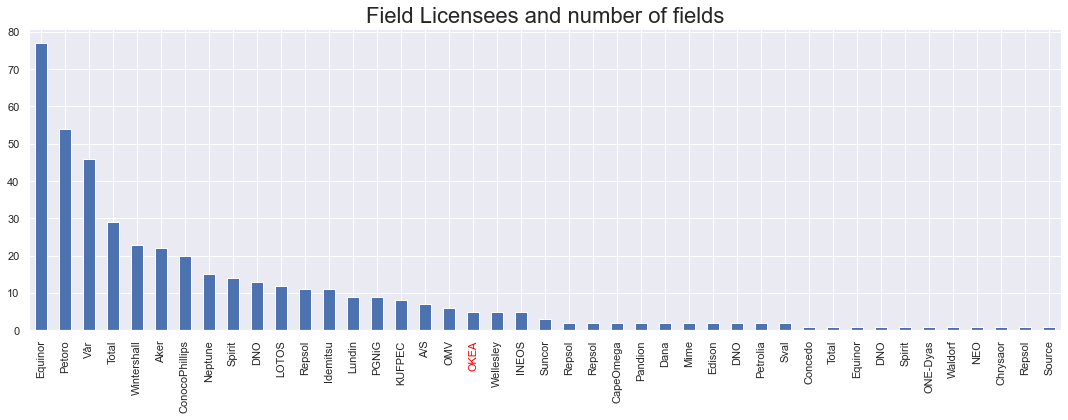

In [8]:
fig, ax = plt.subplots(figsize=(15, 6), tight_layout=True)
data.plot(kind='bar')
ax.xaxis.set_ticklabels(labelf)
plt.xticks(rotation=90); plt.title('Field Licensees and number of fields', fontsize=22)
plt.gca().get_xticklabels()[select-1].set_color('red')
plt.savefig('./figures/Field_licensees.png')
plt.show()

In [9]:
company_licences = licensees[licensees['cmpLongName']==company]
company_licences = company_licences.loc[company_licences.groupby('fldName').fldLicenseeFrom.idxmax(),:]

## Print the number of Fields that the selected company has an interest in

In [10]:
print(f"Number of Fields for {company}: {len(company_licences)}")

Number of Fields for OKEA ASA: 5


In [11]:
company_fields = company_licences['fldName']
company_fields

880        DRAUGEN
2334          GJØA
3259    IVAR AASEN
7451          VARG
8209           YME
Name: fldName, dtype: object

In [12]:
inplacevols = load(fields[6])

# In place volumes for specified Company

In [13]:
company_inplacevols = calculate(company_fields, inplacevols)
company_inplacevols.to_csv('./export/in_place_volumes.csv', index=False);

In [14]:
company_inplacevols

,fldName,fldInplaceOil,fldInplaceAssLiquid,fldInplaceAssGas,fldInplaceFreeGas,fldDateOffResEstDisplay,fldNpdidField
12,DRAUGEN,224.0,0.0,12.0,0.00,2019-12-31,43758.0
30,GJØA,52.0,13.0,10.0,54.01,2019-12-31,4467574.0
46,IVAR AASEN,47.0,0.0,7.0,2.36,2019-12-31,23384520.0
107,VARG,43.0,0.0,5.0,0.00,2019-12-31,43451.0
117,YME,55.0,0.0,3.0,0.00,2019-12-31,43807.0
Total,NaN,421.0,13.0,37.0,56.37,NaT,27983110.0


In [15]:
# Field reserves
reserves = load(fields[5])
# Field reserves at Company share ('fldCompanyShare')
reserves_comp = load(fields[-1]) 

# Reserves for each Field the specified company has an interest in

In [16]:
reserves_comp = reserves_comp[reserves_comp['cmpLongName']==company]
reserves_comp.drop(['cmpLongName', 'cmpDateOffResEstDisplay', 'fldNpdidField', 'cmpNpdidCompany'], axis=1, inplace=True)
reserves_comp.loc['Total'] = reserves_comp.sum(numeric_only=True, axis=0)
reserves_comp.to_csv('./export/reserves_company.csv', index=False)
reserves_comp

,fldName,cmpRemainingOil,cmpRemainingGas,cmpRemainingNGL,cmpRemainingCondensate,cmpRemainingOE,cmpShare
204,DRAUGEN,4.19,0.00,0.01,0.0,4.21,44.560
205,GJØA,0.31,1.20,0.27,0.0,2.02,12.000
206,IVAR AASEN,0.09,0.01,0.00,0.0,0.10,0.554
207,VARG,0.00,0.00,0.00,0.0,0.00,40.000
208,YME,1.73,0.00,0.00,0.0,1.73,15.000
Total,NaN,6.32,1.21,0.28,0.0,8.06,112.114


## Display total reserves for each field - not company share.

In [17]:
company_reserves = calculate(company_fields, reserves)
company_reserves.to_csv('./export/reserves_all.csv', index=False)
company_reserves

,fldName,fldRecoverableOil,fldRecoverableGas,fldRecoverableNGL,fldRecoverableCondensate,fldRecoverableOE,fldRemainingOil,fldRemainingGas,fldRemainingNGL,fldRemainingCondensate,fldRemainingOE,fldDateOffResEstDisplay,fldNpdidField
12,DRAUGEN,151.17,1.68,2.64,0.00,157.87,9.41,0.00,0.02,0.0,9.45,2019-12-31,43758.0
30,GJØA,16.01,40.57,9.89,0.00,75.37,2.60,9.96,2.25,0.0,16.84,2019-12-31,4467574.0
46,IVAR AASEN,23.67,4.04,0.68,0.00,29.00,15.45,2.38,0.40,0.0,18.59,2019-12-31,23384520.0
107,VARG,16.33,0.30,0.02,0.02,16.69,0.00,0.00,0.00,0.0,0.00,2019-12-31,43451.0
117,YME,19.44,0.00,0.00,0.00,19.44,11.53,0.00,0.00,0.0,11.53,2019-12-31,43807.0
Total,NaN,226.62,46.59,13.23,0.02,298.37,38.99,12.34,2.67,0.0,56.41,NaT,27983110.0


# Overview

In [18]:
overview = load(fields[0])

## Breakdown of all fields on the NCS

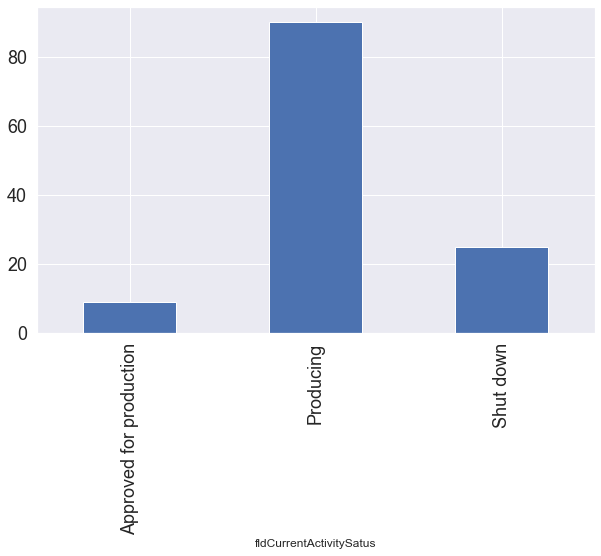

In [19]:
overview.groupby('fldCurrentActivitySatus').size().plot(kind='bar', figsize=(10,6), fontsize=18)
plt.savefig('./figures/All_Fields.png'); plt.show()

In [20]:
producing_fields = overview[overview['fldCurrentActivitySatus']=='Producing']['cmpLongName'].value_counts()
producing_approved_fields = overview[overview['fldCurrentActivitySatus'].isin(['Approved for production'])]['cmpLongName'].value_counts()
shutdown_fields = overview[overview['fldCurrentActivitySatus']=="Shut down"]['cmpLongName'].value_counts()

print(f"Number of fields: {overview.shape[0]}")
print(f"Number of producing fields: {producing_fields.sum()}")
print(f"Number of producing and approved fields: {producing_approved_fields.sum()}")
print(f"Number of shut down fields: {shutdown_fields.sum()}") # doesn't include 3 NaN entries

Number of fields: 124
Number of producing fields: 90
Number of producing and approved fields: 9
Number of shut down fields: 22


## Status of Fields by Area

fldCurrentActivitySatus  Approved for production  Producing  Shut down
fldMainArea                                                           
Barents Sea                                  1.0        2.0        NaN
North Sea                                    6.0       67.0       24.0
Norwegian Sea                                2.0       21.0        1.0
Column Total                                 9.0       90.0       25.0


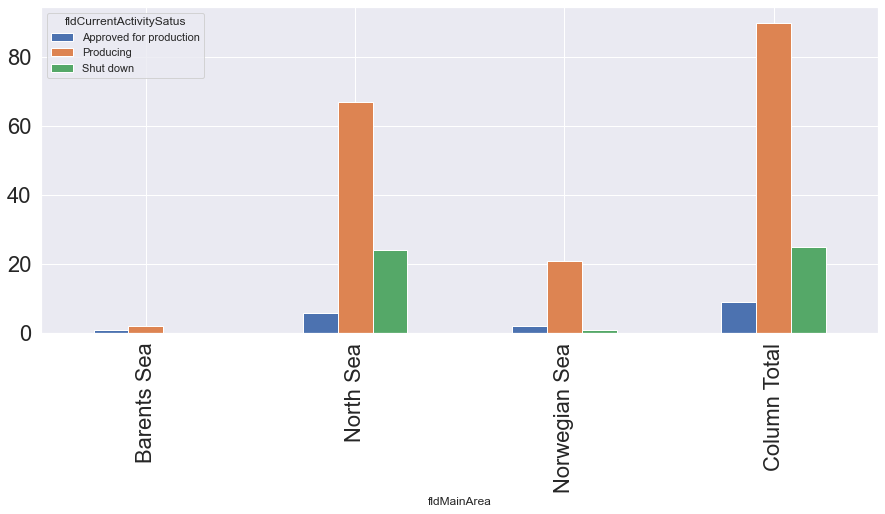

In [21]:
data = overview.groupby(['fldMainArea', 'fldCurrentActivitySatus']).size().unstack()
data.loc['Column Total'] = data.sum(numeric_only=True, axis=0)
print(data)
data.plot(kind='bar', figsize=(15,6), fontsize=22)
plt.savefig('./figures/Fields by Area.png'); plt.show()

# Backup

In [22]:
investments_yearly_by_field = 'https://factpages.npd.no/ReportServer_npdpublic?/FactPages/TableView/field_investment_yearly&rs:Command=Render&rc:Toolbar=false&rc:Parameters=f&rs:Format=CSV&Top100=false&IpAddress=not_used&CultureCode=en'

# Status

In [23]:
status = load(fields[1])

In [24]:
# status.head()

In [25]:
status.dropna(inplace=True)
status = status.loc[status.groupby('fldName').fldStatusToDate.idxmax(),:]

In [26]:
status['fldStatus'].value_counts()
#  the headings and values look transposed

Approved for production    91
Producing                  24
Shut down                   1
Name: fldStatus, dtype: int64

In [27]:
status['fldName'].nunique()

116

# Operators

In [28]:
operators = load(fields[2])

In [29]:
print(f" Number of Operators: {operators['cmpLongName'].nunique()}")
print(f" Number of Fields: {operators['fldName'].nunique()}")

 Number of Operators: 78
 Number of Fields: 124


In [30]:
# Current Operators don't have a date in the 'fldOperatorTo' field
operators[operators['fldOperatorTo'].isnull()]['cmpLongName'].value_counts() # 121 - doesn't include NaN

Equinor Energy AS                   59
Aker BP ASA                         19
ConocoPhillips Skandinavia AS        9
Wintershall Dea Norge AS             5
Vår Energi AS                        5
Repsol Norge AS                      4
Neptune Energy Norge AS              3
A/S Norske Shell                     3
Lundin Energy Norway AS              3
DNO Norge AS                         2
Spirit Energy Norway AS              2
Total E&P Norge AS                   2
Chrysaor Norge AS                    1
Repsol Sinopec North Sea Limited     1
OKEA ASA                             1
Petrogas NEO UK Ltd                  1
Total E&P UK Ltd                     1
Name: cmpLongName, dtype: int64

# Description

In [31]:
description = load(fields[7])

In [32]:
description.head()

,fldName,fldDescriptionHeading,fldDescriptionText,fldNpdidField,fldDescriptionDateUpdated
0,ALBUSKJELL,Development,Albuskjell is a field in the southern part of ...,43437,2020-02-08
1,ALBUSKJELL,Reservoir,Albuskjell produced gas and condensate from Ma...,43437,2018-03-16
2,ALBUSKJELL,Recovery,The field was produced by pressure depletion.,43437,2017-04-11
3,ALBUSKJELL,Transport,The well stream was transported via pipeline t...,43437,2018-03-16
4,ALBUSKJELL,Status,The field was shut down in 1998 and the platfo...,43437,2020-02-08
